In [1]:
library(rtracklayer)
library(SummarizedExperiment)
library(DESeq2)
library(Rsubread)
library(data.table)
library(tidyverse)
library(pheatmap)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: MatrixGenerics

Loading required package: matrixStats




In [2]:
gtf <- rtracklayer::import('/Genomics/pritykinlab/share/eileen-rnaseq/mm10/gencode.vM23.annotation.gtf')
# gtf_df=as.data.frame(gtf)

In [9]:
gencode <- keepStandardChromosomes(gtf, pruning.mode = "coarse")

In [86]:
# input
bamdir <- "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA"
bamfiles <- list.files(bamdir, pattern = "*.bam$")
bamfiles <- c(bamfiles[1:5], bamfiles[31:35])
bamfiles.full <- paste0(bamdir, "/", bamfiles)

In [88]:
length(bamfiles.full)

[1] 10

In [89]:
# genes and exons
print("Prepare collection of all exons for genes in GENCODE")
genes <- levels(as.factor(gencode$gene_name))
exons <- gencode[gencode$type == 'exon']
exons.genes <- disjoin(split(exons, factor(exons$gene_name, levels = genes)))
print("prepared")

[1] "Prepare collection of all exons for genes in GENCODE"
[1] "prepared"


In [91]:
# count reads in exons
print("Count overlaps of genes (all exons) with reads")
print("Use files:")
print(bamfiles.full)
exons.table <- as.data.frame(exons) %>%
                   dplyr::select(GeneID = gene_name, Chr = seqnames,
                                 Start = start, End = end, Strand = strand)
# by some reason the commented command below that runs featureCounts()
# for all files at once doesn't work and aborts the R session on Rstudio,
# so have to run files one by one, which works fine
# gene.counts <- sapply(bamfiles.full,
#     function(filename) {
#         print(filename)
#         gene.counts.filename <-
#             featureCounts(filename, annot.ext = exons.table,
#                           isPairedEnd = TRUE,
#                           requireBothEndsMapped = TRUE,
#                           fracOverlap = 0.8,
#                           countChimericFragments = FALSE, nthreads = 12)
#         print(colSums(gene.counts.filename$counts))
#         gene.counts.filename
#     }
# )
gene.counts <- featureCounts(bamfiles.full, annot.ext = exons.table,
                             isPairedEnd = TRUE, requireBothEndsMapped = TRUE,
                             minOverlap = 80,
                             countChimericFragments = FALSE,
                             nthreads = 10)

[1] "Count overlaps of genes (all exons) with reads"
[1] "Use files:"
 [1] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12DarkATG7KOfemale1911-21-GNP.bam"        
 [2] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12DarkATG7KOfemale1911-22-iWAT.bam"       
 [3] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12DarkATG7KOfemale1911-23-BAT.bam"        
 [4] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12DarkATG7KOfemale1911-24-Liver.bam"      
 [5] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12DarkATG7KOfemale1911-25-Cerebellum.bam" 
 [6] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12LightATG7KOfemale1390-16-GNP.bam"       
 [7] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12LightATG7KOfemale1390-17-BAT.bam"       
 [8] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12LightATG7KOfemale1390-18-iWAT.bam"      
 [9] "/Genomics/pritykinlab/share/eileen-rnaseq/bam-RNA/12LightATG7KOfemale1390-19-Cerebellum.bam"
[10] "/Genomics/pritykinlab/share/eilee

In [92]:
attributes(gene.counts)

$names
[1] "counts"     "annotation" "targets"    "stat"

In [93]:
# print("count complete, save the result")
# saveRDS(gene.counts, "datafiles/rna-counts-batch3.raw.rds")

In [95]:
head(gene.counts$counts)

,12DarkATG7KOfemale1911-21-GNP.bam,12DarkATG7KOfemale1911-22-iWAT.bam,12DarkATG7KOfemale1911-23-BAT.bam,12DarkATG7KOfemale1911-24-Liver.bam,12DarkATG7KOfemale1911-25-Cerebellum.bam,12LightATG7KOfemale1390-16-GNP.bam,12LightATG7KOfemale1390-17-BAT.bam,12LightATG7KOfemale1390-18-iWAT.bam,12LightATG7KOfemale1390-19-Cerebellum.bam,12LightATG7KOfemale1390-20-Liver.bam
4933401J01Rik,0,0,0,0,0,0,0,0,0,0
Gm26206,0,0,0,0,0,0,0,0,0,0
Xkr4,2,7,6,0,168,3,7,1,198,0
Gm18956,0,0,0,0,0,0,0,0,0,0
Gm37180,0,0,0,0,0,0,0,0,4,0
Gm37363,0,0,0,0,0,0,0,1,4,0


In [96]:
gene.counts.df <- as.data.frame(gene.counts$counts)
samplenames <- sapply(strsplit(bamfiles, ".bam"), "[", 1)
print("use these sample names:")
print(samplenames)
print("for these bam files in exactly the same order:")
print(bamfiles)
colnames(gene.counts.df) <- samplenames

[1] "use these sample names:"
 [1] "12DarkATG7KOfemale1911-21-GNP"        
 [2] "12DarkATG7KOfemale1911-22-iWAT"       
 [3] "12DarkATG7KOfemale1911-23-BAT"        
 [4] "12DarkATG7KOfemale1911-24-Liver"      
 [5] "12DarkATG7KOfemale1911-25-Cerebellum" 
 [6] "12LightATG7KOfemale1390-16-GNP"       
 [7] "12LightATG7KOfemale1390-17-BAT"       
 [8] "12LightATG7KOfemale1390-18-iWAT"      
 [9] "12LightATG7KOfemale1390-19-Cerebellum"
[10] "12LightATG7KOfemale1390-20-Liver"     
[1] "for these bam files in exactly the same order:"
 [1] "12DarkATG7KOfemale1911-21-GNP.bam"        
 [2] "12DarkATG7KOfemale1911-22-iWAT.bam"       
 [3] "12DarkATG7KOfemale1911-23-BAT.bam"        
 [4] "12DarkATG7KOfemale1911-24-Liver.bam"      
 [5] "12DarkATG7KOfemale1911-25-Cerebellum.bam" 
 [6] "12LightATG7KOfemale1390-16-GNP.bam"       
 [7] "12LightATG7KOfemale1390-17-BAT.bam"       
 [8] "12LightATG7KOfemale1390-18-iWAT.bam"      
 [9] "12LightATG7KOfemale1390-19-Cerebellum.bam"
[10] "12LightATG7KOfemale1

In [97]:
# process and save results
gene.counts.mat <- as.matrix(gene.counts.df)
gene.names <- sort(names(exons.genes))
gene.counts.mat <- gene.counts.mat[gene.names, ]
# gene.counts <- gene.counts[rowSums(gene.counts) > 0, ]
exons.genes <- exons.genes[gene.names]
gene.counts.se <- SummarizedExperiment(list(counts = gene.counts.mat),
                                       rowRanges = exons.genes)


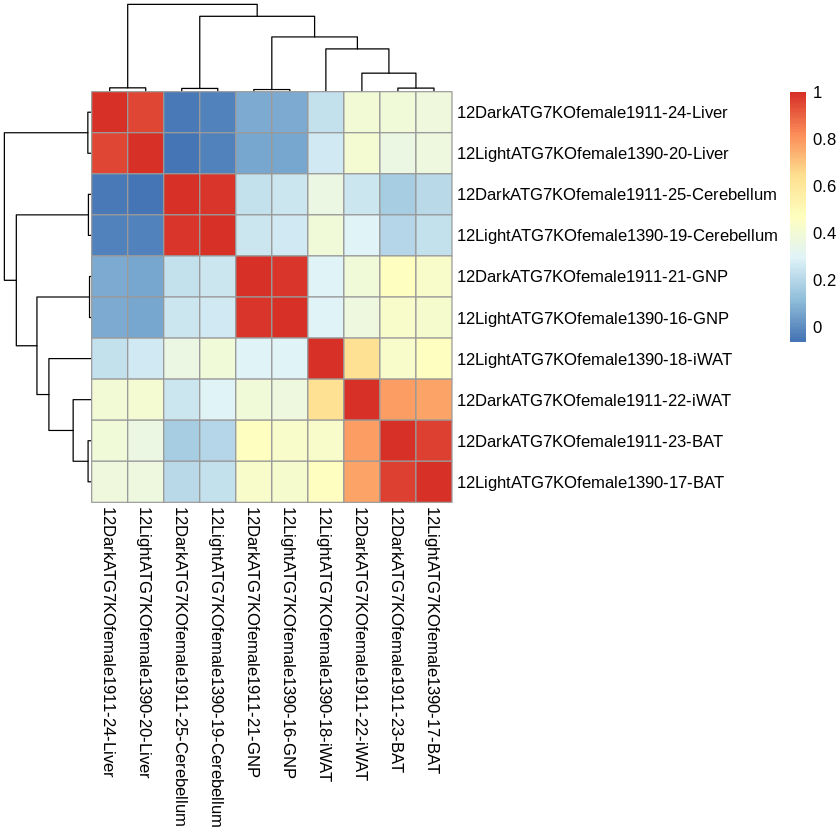

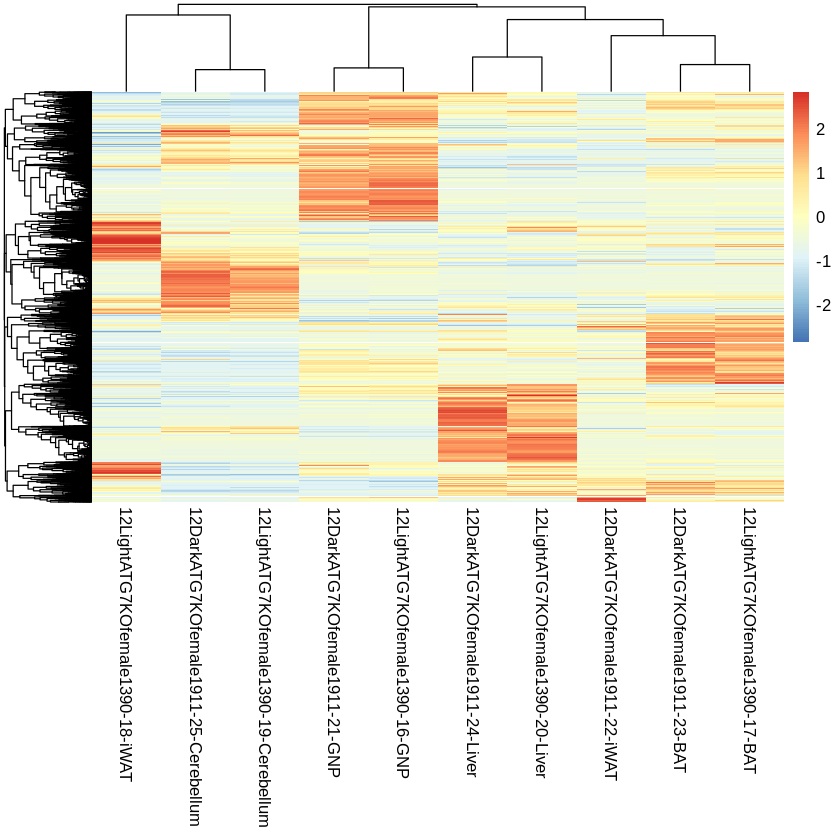

In [99]:
dds <- DESeqDataSet(gene.counts.se, design = as.formula("~1"))
dds <- estimateSizeFactors(dds)
normalized.counts <- counts(dds, normalized = TRUE)
# get top 5000 genes
normalized.counts <-
    normalized.counts[order(-rowMeans(normalized.counts)), ][1:5000, ]
normalized.counts.cor <- cor(normalized.counts, method = "spearman")
# pdf("plots/heatmap-normcounts-cor.pdf", onefile = FALSE,
#     width = 8, height = 8)
pheatmap(normalized.counts.cor)
# dev.off()
# pdf("plots/heatmap-normcounts.pdf", onefile = FALSE,
#     width = 8, height = 10)
pheatmap(normalized.counts, scale = "row", show_rownames = FALSE)
# dev.off()

In [100]:
samplenames

[1] "12DarkATG7KOfemale1911-21-GNP"        
 [2] "12DarkATG7KOfemale1911-22-iWAT"       
 [3] "12DarkATG7KOfemale1911-23-BAT"        
 [4] "12DarkATG7KOfemale1911-24-Liver"      
 [5] "12DarkATG7KOfemale1911-25-Cerebellum" 
 [6] "12LightATG7KOfemale1390-16-GNP"       
 [7] "12LightATG7KOfemale1390-17-BAT"       
 [8] "12LightATG7KOfemale1390-18-iWAT"      
 [9] "12LightATG7KOfemale1390-19-Cerebellum"
[10] "12LightATG7KOfemale1390-20-Liver"

In [101]:
repnames <- c(rep("Dark", 5), rep("Light", 5))

fileinfo <- data.table(sample = samplenames,
                       rep = repnames)
fileinfo

sample,rep
<chr>,<chr>
12DarkATG7KOfemale1911-21-GNP,Dark
12DarkATG7KOfemale1911-22-iWAT,Dark
12DarkATG7KOfemale1911-23-BAT,Dark
12DarkATG7KOfemale1911-24-Liver,Dark
12DarkATG7KOfemale1911-25-Cerebellum,Dark
12LightATG7KOfemale1390-16-GNP,Light
12LightATG7KOfemale1390-17-BAT,Light
12LightATG7KOfemale1390-18-iWAT,Light
12LightATG7KOfemale1390-19-Cerebellum,Light


In [102]:
repnames <- c(rep("Dark", 5), rep("Light", 5))

fileinfo <- data.table(sample = samplenames,
                       rep = repnames)

gene.counts.se <- SummarizedExperiment(list(counts = gene.counts.mat),
                                       rowRanges = exons.genes)
fileinfo <- as.data.frame(fileinfo)
rownames(fileinfo) <- fileinfo$sample
colData(gene.counts.se) <- cbind(colData(gene.counts.se), fileinfo)

# estimate size factors using all genes
dds <- DESeqDataSet(gene.counts.se, design = as.formula("~1"))
dds <- estimateSizeFactors(dds)
colData(gene.counts.se)$sizeFactor <- sizeFactors(dds)

normCounts <- function(se) {
    # assign normalized count values to DESeqDataSet object
    # assume rowRanges is a non-empty GRangesList
    # and size factors were computed earlier
    # (e.g., using estimateSizeFactors())
    gene.length <- sum(width(rowRanges(se)))
    counts.norm <- apply(counts(se, normalized = TRUE), 2,
                        function(x){
                            1e3 * x / gene.length
                        })
    assays(se)$counts.norm <- counts.norm
    return(se)
}

dds <- normCounts(dds)
assays(gene.counts.se)$counts.norm <- assays(dds)$counts.norm

Saving 6.67 x 6.67 in image



R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Springdale Linux 7.9 (Verona)

Matrix products: default
BLAS/LAPACK: /Genomics/grid/users/zz5084/anaconda3/envs/deseq/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pheatmap_1.0.12             forcats_0.5.1              
 [3] stringr_1.4.0               dplyr_1.0.9                
 [5] purrr_0.3.4                 readr_2.1.2                
 [7] tidyr_1.2.0                 tibble_3.1.7               
 [9] ggplot2_3.3.6    

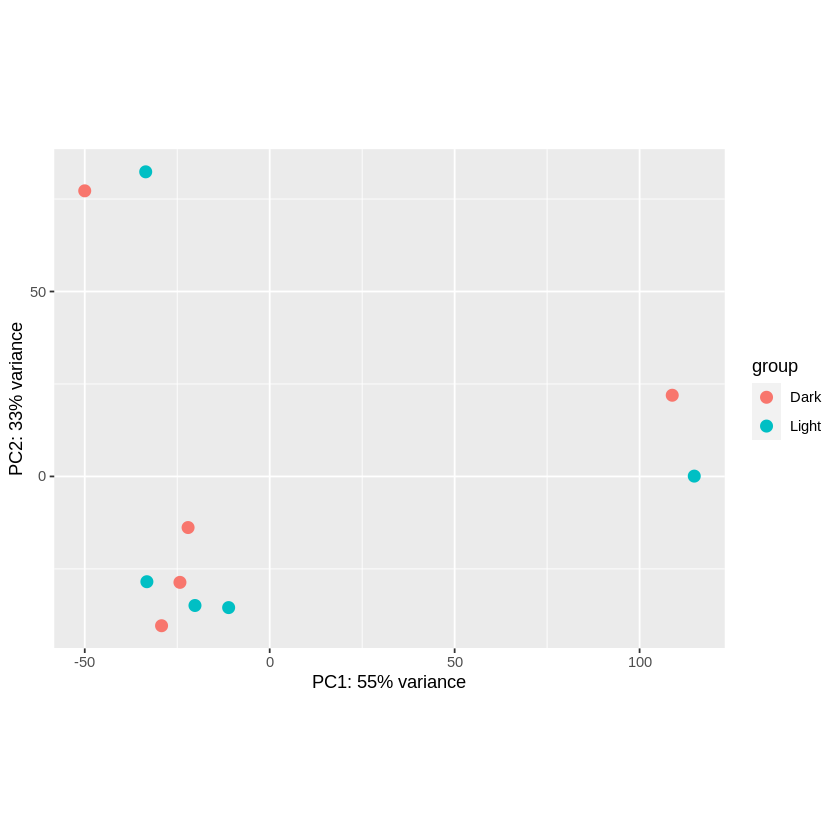

In [103]:
# saveRDS(gene.counts.se, "datafiles/rna-counts-batch3.rds")

vsd <- varianceStabilizingTransformation(dds, blind = FALSE)
plotPCA(vsd, intgroup = c("rep"))
ggsave("plots/pca-genes-counts-batch3.pdf")

sessionInfo()